In [180]:
#!pip install catboost
#!pip install xgboost
#!pip install lightgbm

In [2]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from datetime import date
import requests
from itertools import combinations
from scipy.stats import pearsonr, chi2_contingency
from scipy.stats import poisson
from catboost import Pool, CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, precision_recall_curve, roc_curve
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from time import time
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import xgboost as xgb
from xgboost import plot_importance
from sklearn.metrics import log_loss
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMClassifier
import seaborn as sns
sns.set()

In [241]:
#load data from sportsdatabase.com
nbastats = pd.read_csv('nba_stats_05-19.csv')

In [242]:
nbastats.shape

(38240, 63)

In [243]:
#make a matchup column where each matchup is the same i.e. x vs y
#nbastats['matchup'] = 0

#for row, index in zip(nbastats.values, nbastats.index):
#    matchup = row[1] + ' ' + row[3]
#    nbastats['matchup'][index] = matchup

In [244]:
#make a matchup column where each matchup is the same i.e. x vs y and none are y vs x
nbastats['matchup'] = 0

for row, index in zip(nbastats.values, nbastats.index):
    matchup = row[1] + ' ' + row[3]
    matchups = matchup.split(' ')
    matchups.sort()
    matchupz = ' '.join(matchups)
    nbastats['matchup'][index] = matchupz

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [245]:
#make column where >=finalscore-vegasline is 1 and < is 0
nbastats['o/u'] = 0
nbastats.loc[nbastats['o/u margin'] >= 0, 'o/u'] = 1
nbastats.loc[nbastats['o/u margin'] < 0, 'o/u'] = 0

In [246]:
#column for win loss stat
nbastats['WL'] = 0
nbastats.loc[nbastats['points'] > nbastats['op points'], 'WL'] = 1
nbastats.loc[nbastats['points'] < nbastats['op points'], 'WL'] = -1

In [247]:
#convert conference to number
nbastats.loc[nbastats['conference west/east'] == 'Western', 'conference west/east'] = 1
nbastats.loc[nbastats['conference west/east'] == 'Eastern', 'conference west/east'] = 0

In [248]:
#convert home away to number
nbastats.loc[nbastats['home away'] == 'home', 'home away'] = 1
nbastats.loc[nbastats['home away'] == 'away', 'home away'] = 0

In [249]:
#make column where >=finalscore-vegasline is 1 and < is 0
nbastats['o/u margin class'] = 0

mthresh = 10

nbastats.loc[nbastats['o/u margin'] >= mthresh, 'o/u margin class'] = 1
nbastats.loc[(nbastats['o/u margin'] < mthresh) & 
             (nbastats['o/u margin'] > -mthresh), 'o/u margin class'] = 0
nbastats.loc[nbastats['o/u margin'] <= -mthresh, 'o/u margin class'] = -1

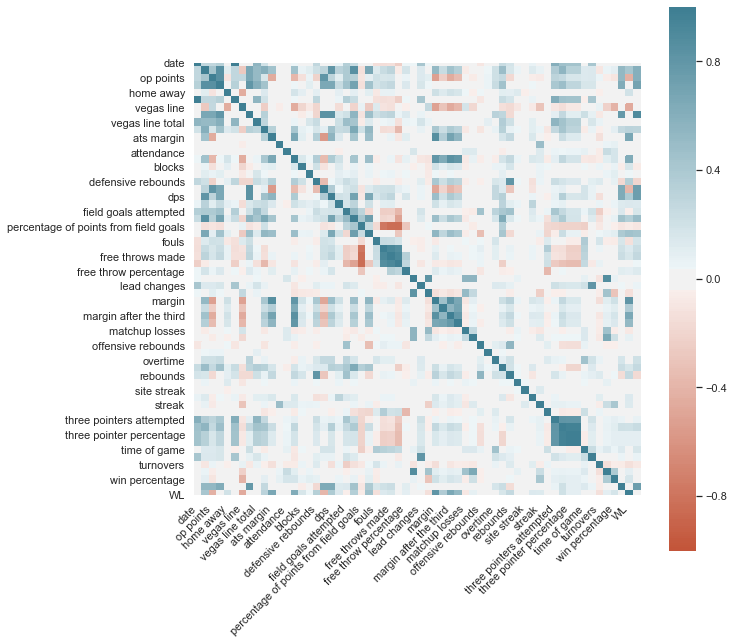

In [191]:
#Correlation Matrix
corr = nbastats.corr()
fig, ax = plt.subplots(figsize=(10,10))
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

In [192]:
#onehot the timezone, diision, and day columns
#nbastats = pd.get_dummies(nbastats, prefix_sep="__", columns=['time zone', 'division', 'day'])

In [193]:
#drop any nans
#nbastats = nbastats.dropna()
#nbastats = nbastats.reset_index(drop=True)

In [250]:
#percentage of nans
nan_mean = (nbastats.isna().mean() * 100).round(3)
nan_mean = nan_mean[nan_mean != 0].sort_values()
nan_mean

margin after the first                      0.010
overtime                                    0.010
margin at the half                          0.010
margin after the third                      0.010
percentage of points from three pointers    0.026
three pointer percentage                    0.026
three pointers made                         0.026
three pointers attempted                    0.026
steals                                      0.026
rebounds                                    0.026
officials                                   0.026
offensive rebounds                          0.026
free throw percentage                       0.026
assists                                     0.026
free throws made                            0.026
blocks                                      0.026
defensive rebounds                          0.026
percentage of points from free throws       0.026
field goals made                            0.026
percentage of points from field goals       0.026


In [251]:
#fill numerical nans with mean from whole data set, hopefully not too much leakage
#should use means from each season
fill_mean = nan_mean.index.values
nbastats[fill_mean] = nbastats[fill_mean].fillna(nbastats[fill_mean].mean())

In [252]:
#fill cat. nans with ['NA']
nbastats['officials'] = nbastats['officials'].fillna('NA')

In [253]:
#remaining categorical columns
cat_feat = nbastats.select_dtypes('object').columns.values
nbastats[cat_feat].nunique().sort_values()

time zone        4
division         6
day              7
team            31
op team         31
matchup        464
officials    15038
dtype: int64

In [254]:
def highcorrelation(df, thresh):
    num_feat = df.select_dtypes('number').columns.values
    comb_num_feat = np.array(list(combinations(num_feat, 2)))
    corr_num_feat = np.array([])

    for comb in comb_num_feat:
        corr = pearsonr(df[comb[0]], df[comb[1]])[0]
        corr_num_feat = np.append(corr_num_feat, corr)
    high_corr_num = comb_num_feat[np.abs(corr_num_feat) >= thresh]
    return high_corr_num

In [201]:
highcorrelation(nbastats, .8)

array([['o/u margin', 'o/u margin class']], dtype='<U22')

In [255]:
#drop highly correlated values and make a new df
nbastats = nbastats.drop(['date', 'total points', 'dps', 'field goals made', 'dpa', 
                          'ats margin', 'margin', 'margin after the third', 'time zone__E', 
                          'rebounds', 'percentage of points from field goals', 'free throws attempted',
                          'percentage of points from free throws','game number', 'times tied',
                          'three pointers attempted', 'three pointer percentage',
                          'percentage of points from three pointers'], axis=1, errors='ignore')

In [256]:
nbastats.columns

Index(['team', 'points', 'op team', 'op points', 'home away', 'season',
       'vegas line', 'o/u margin', 'vegas line total', 'assists', 'ats streak',
       'attendance', 'biggest lead', 'blocks', 'conference west/east', 'day',
       'defensive rebounds', 'division', 'fast break points',
       'field goals attempted', 'field goal percentage', 'fouls',
       'free throws made', 'free throw percentage', 'lead changes', 'losses',
       'margin after the first', 'margin at the half', 'matchup losses',
       'matchup wins', 'offensive rebounds', 'officials', 'ou streak',
       'overtime', 'points in the paint', 'rest', 'site streak', 'steals',
       'streak', 'team rebounds', 'three pointers made', 'time of game',
       'time zone', 'turnovers', 'wins', 'win percentage', 'matchup', 'o/u',
       'WL', 'o/u margin class'],
      dtype='object')

In [257]:
#ingame/postgame stats excluding o/u stats
in_game_mask = ['matchup', 'points', 'op points', 'assists', 'biggest lead', 'blocks', 
       'defensive rebounds', 'fast break points', 'field goals attempted',
       'field goal percentage', 'fouls', 'free throws made',
       'free throw percentage', 'lead changes', 'margin after the first', 'margin at the half', 
        'overtime', 'offensive rebounds', 'points in the paint', 'steals',
       'team rebounds', 'three pointers made', 'time of game',
       'turnovers', 'WL']

#in_game_mask = ['matchup', 'points', 'op points', 'assists', 'biggest lead', 'blocks', 
#       'defensive rebounds', 'fast break points', 'field goals attempted',
#       'field goal percentage', 'fouls', 'free throws made',
#       'free throw percentage', 'lead changes','margin after the first', 'margin at the half', 
#       'offensive rebounds', 'overtime', 'points in the paint', 'steals',
#       'team rebounds', 'three pointers made', 'time of game',
#       'turnovers', 'WL']

ema_mask = ['points', 'op points', 'assists', 'biggest lead', 'blocks', 
       'defensive rebounds', 'fast break points', 'field goals attempted',
       'field goal percentage', 'fouls', 'free throws made',
       'free throw percentage', 'lead changes','margin after the first', 'margin at the half', 
       'offensive rebounds', 'overtime', 'points in the paint', 'steals',
       'team rebounds', 'three pointers made', 'time of game',
       'turnovers', 'WL']

#pregame stats
ext_game_mask = ['team', 'op team', 'home away',
       'vegas line', 'vegas line total', 'ats streak',
       'attendance', 'conference west/east', 'day',
       'division', 'losses',
       'matchup losses',
       'matchup wins', 'ou streak',
       'rest', 'site streak',
       'streak', 
       'time zone', 'wins', 'win percentage', 'matchup',
       'WL']

#ext_game_mask = ['team', 'op team', 'home away', 'season',
#       'vegas line', 'vegas line total', 'ats streak',
#       'attendance', 'conference west/east',
#       'losses', 'matchup losses', 'matchup wins', 'officials', 'ou streak',
#       'rest', 'site streak', 'streak', 'wins', 'win percentage', 'matchup',
#       'time zone__C', 'time zone__M', 'time zone__P', 'division__Atlantic',
#       'division__Central', 'division__Northwest', 'division__Pacific',
#       'division__Southeast', 'division__Southwest', 'day__Friday',
#       'day__Monday', 'day__Saturday', 'day__Sunday', 'day__Thursday',
#       'day__Tuesday', 'day__Wednesday']

In [520]:
# Define a function which creates an EMA DataFrame from the stats DataFrame
def create_stats_features_ema(span):
    # Create a copy of the DataFrame
    ema = nbastats.copy()

    # Get the columns that we want to create EMA for
    feature_names = ema_mask

    # Loop over the features
    for feature_name in feature_names:
        feature_ema = (ema.groupby('team')[feature_name] # Calculate the EMA
                                                  .transform(lambda row: round(row.ewm(span=span, 
                                                    min_periods=2).mean().shift(1), 3))) 
                                                # Shift the data down 1 so we don't leak data
        ema[feature_name] = feature_ema # Add the new feature to the DataFrame
    return ema

In [521]:
nbastats_ema = create_stats_features_ema(span=3)

In [522]:
away_columns = ['team', 'points', 'home away',
       'vegas line', 'assists', 
       'biggest lead', 'blocks', 'conference west/east',
       'defensive rebounds', 'division', 'fast break points',
       'field goals attempted', 'field goal percentage', 'fouls',
       'free throws made', 'free throw percentage', 'losses',
       'margin after the first', 'margin at the half', 'matchup losses',
       'matchup wins', 'offensive rebounds', 'ou streak',
       'points in the paint', 'rest', 'site streak', 'steals',
       'streak', 'team rebounds', 'three pointers made',
       'time zone', 'turnovers', 'wins', 'win percentage',
       'WL']
home_columns = ['team', 'points', 'home away',
       'vegas line', 'assists', 
       'biggest lead', 'blocks', 'conference west/east',
       'defensive rebounds', 'division', 'fast break points',
       'field goals attempted', 'field goal percentage', 'fouls',
       'free throws made', 'free throw percentage', 'losses',
       'margin after the first', 'margin at the half', 'matchup losses',
       'matchup wins', 'offensive rebounds', 'ou streak',
       'points in the paint', 'rest', 'site streak', 'steals',
       'streak', 'team rebounds', 'three pointers made',
       'time zone', 'turnovers', 'wins', 'win percentage',
       'WL']


In [523]:
nbastats_ema_away = nbastats_ema[1::2][away_columns]
nbastats_ema_home = nbastats_ema[::2]

nbastats_ema_away = nbastats_ema_away.reset_index(drop=True)
nbastats_ema_home = nbastats_ema_home.reset_index(drop=True)

nbastats_ema_away = (nbastats_ema_away.rename(columns={col: col + '_Away' 
                                                       for col in nbastats_ema_away.columns}))
nbastats_ema_home = (nbastats_ema_home.rename(columns={col: col + '_Home' 
                                                       for col in home_columns}))
nbastats_ema_homeaway = pd.concat([nbastats_ema_home, nbastats_ema_away], axis=1, join='inner')
nbastats_ema_homeaway = nbastats_ema_homeaway.drop(['op team', 'op points'], axis=1)

In [524]:
nbastats_ema_homeaway = nbastats_ema_homeaway.dropna()
nbastats_ema_homeaway = nbastats_ema_homeaway.reset_index(drop=True)

In [525]:
#build one data frame ordered by season 05, 06,..19 etc. but after each season add average of ingame/postgame stats
#for cross validation with 05 as train and average of 05 ingame and 06 external stats as test, next 07 ingame as train and
#average of 08 and 09 external for test, like 05<06>, 07<08>...16<17>. As the final untouched test set use 18,<19>. This is to
#preserve the time order of the games
#[05,06,07,08,09,...16]
#[(<05>,06),(<07>,08),(<09>,10),...(<16>,17)]
#concat,concat,concat...
#05(<05>,06) 07(<07>,08) 09(<09>,10)...
X_train = nbastats_ema_homeaway.copy()
X_test = nbastats_ema_homeaway.copy()

X_train_set = []
for i in range(2006, 2020):
    X_train_set.append(X_train[X_train['season'] == i])

X_test_set = []
for i in range(2006, 2020):
    X_test_set.append(X_test[X_test['season'] == i])

In [526]:
#average up ingame/postgame stats by matchup in training set to apply to test set's matchups,
#this way we are not using data in the test that would be unknown at the time of placing an
#actual bet pregame
#for i in range(1, len(X_train_set)):
    #get averages of previous season
#    ma = X_train_set[i-1][in_game_mask]
#    matchup_averages = ma.groupby(by='matchup', as_index=True).mean()
    #matchup_averages.reset_index(drop=True, inplace=True)
        
    #impute averages of ingame stats from training set into ingame stat columns in test set
#    for j in in_game_mask:
#        if j == 'matchup':
#            continue    
#        for index, row in X_test_set[i].iterrows():
#            a = row['matchup']
#            if a not in matchup_averages.index:
#                continue
#            X_test_set[i][j][index] = matchup_averages[j][a]

#in_game_mask.remove('matchup')

#for i in in_game_mask:
#    for index, row in X_test.iterrows():
#        X_test[i][index] = matchup_averages[matchup_averages['matchup'] == row['matchup']][i]

In [527]:
#make concatinated train,test and get indices for each train,test for CV, leave out 2018/2019 for final
#test
X_train = pd.concat(X_train_set, ignore_index=True)
X_test = pd.concat(X_test_set, ignore_index=True)

X_train_2016 = X_train[X_train['season']== 2016]
X_test_2017 = X_test[X_test['season'] == 2017]

y_train_2016 = X_train_2016['o/u']
y_test_2017 = X_test_2017['o/u']
y_train = X_train['o/u']
y_test = X_test['o/u']

y_train_cont_2016 = X_train_2016['o/u margin']
y_test_cont_2017 = X_test_2017['o/u margin']
y_train_cont = X_train['o/u margin']
y_test_cont = X_test['o/u margin']

X_train_final = X_train[X_train['season']== 2017]
X_test_final = X_test[X_test['season'] == 2018]

y_train_final = X_train_final['o/u']
y_test_final = X_test_final['o/u']
y_test_cont_final = X_test_final['o/u margin']
    

In [528]:
#X_train_2017.to_csv('NBA2017.csv', index=False)

In [543]:
#2018, 2019 held out
indices = list()
for i in range(2014, 2017):
    train = X_train.loc[X_train['season'] == i].index
    test = X_test.loc[X_test['season'] == i+1].index
    indices.append((train, test))

In [530]:
#fig, axes = plt.subplots(1,1, figsize=(10,10))
#g = sns.PairGrid(X_train_2017.sample(1000), diag_sharey=False)
#g.map_upper(sns.scatterplot, hue='o/u')
#g.map_diag(sns.kdeplot, lw=2)

In [531]:
#fig, axes = plt.subplots(1,1, figsize=(15,5))
#g = sns.scatterplot(x='matchup', y='o/u margin', data=X_train_2017.groupby('matchup', as_index=False).
#                    mean().sort_values('o/u margin', ascending=False))
#g = plt.xticks(rotation=45)

In [532]:
#highcorrelation(X_train, .8)

In [533]:
#highcorrelation(X_test, .8)

In [534]:
droplist = ['o/u margin', 'o/u margin class', 'o/u', 'vegas line_Away', 'margin at the half_Home', 
           'matchup wins_Away', 'matchup losses_Away', 'streak_Home', 'margin at the half_Away', 
           'streak_Away']
X_train = X_train.drop(droplist, axis=1, errors='ignore')
X_test = X_test.drop(droplist, axis=1, errors='ignore')

X_train_2016 = X_train_2016.drop(droplist, axis=1, errors='ignore')
X_test_2017 = X_test_2017.drop(droplist, axis=1, errors='ignore')

X_train_final = X_train_final.drop(droplist, axis=1, errors='ignore')
X_test_final = X_test_final.drop(droplist, axis=1, errors='ignore')

In [535]:
X_train_num = X_train.select_dtypes('number')
X_test_num = X_test.select_dtypes('number')

X_train_2016_num = X_train_2016.select_dtypes('number')
X_test_2017_num = X_test_2017.select_dtypes('number')

X_train_final_num = X_train_final.select_dtypes('number')
X_test_final_num = X_test_final.select_dtypes('number')

In [536]:
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_num), columns = X_train_num.columns)
X_train_2016_scaled = pd.DataFrame(scaler.fit_transform(X_train_2016_num), columns = X_train_2016_num.columns)
X_train_final_scaled = pd.DataFrame(scaler.fit_transform(X_train_final_num), columns = 
                                    X_train_final_num.columns)

X_test_scaled = pd.DataFrame(scaler.fit_transform(X_test_num), columns = X_test_num.columns)
X_test_2017_scaled = pd.DataFrame(scaler.fit_transform(X_test_2017_num), columns = X_test_2017_num.columns)
X_test_final_scaled = pd.DataFrame(scaler.fit_transform(X_test_final_num), 
                                   columns = X_test_final_num.columns)

[10:02:02] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { cosample_bytree } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Accuracy: 51.60%


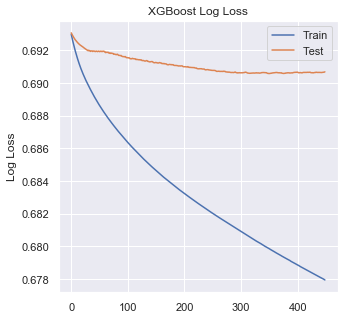

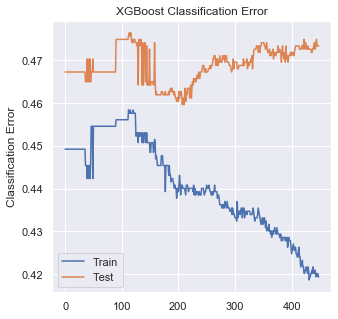

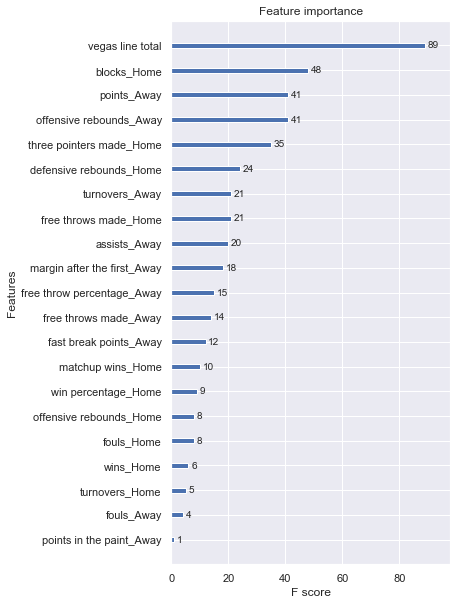

In [537]:
model = xgb.XGBClassifier(seed=968, eta=.02, n_estimators=1000, min_child_weight=1, 
                          max_depth=1, subsample=1, cosample_bytree=1, reg_lambda=10, 
                          reg_alpha=10)
evals_result ={}
eval_s = [(X_train_2016_num, y_train_2016),(X_test_2017_num, y_test_2017)]
model.fit(X_train_2016_num, y_train_2016, eval_metric=["error", "logloss"],
          early_stopping_rounds=100, eval_set=eval_s, verbose=False)

# make predictions for test data
y_pred = model.predict(X_test_final_num)
predictions = [round(value) for value in y_pred]

# evaluate prediction
accuracy = accuracy_score(y_test_final, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

# retrieve performance metrics
results = model.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)

# plot log loss
fig, ax = plt.subplots(figsize=(5,5))
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')
plt.show()

# plot classification error
fig, ax = plt.subplots(figsize=(5,5))
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
plt.ylabel('Classification Error')
plt.title('XGBoost Classification Error')
plt.show()

#plot importance
fig, ax = plt.subplots(figsize = (5,10))
plot_importance(model, ax=ax)
plt.show()


In [538]:
def algorithm_pipeline(X_train_data, X_test_data, y_train_data, y_test_data, 
                       model, param_grid, cv, scoring_fit,
                       probabilities):
    gs = GridSearchCV(
        estimator=model,
        param_grid=param_grid, 
        cv=cv, 
        n_jobs=-1, 
        scoring=scoring_fit,
        verbose=2,
    )
    fitted_model = gs.fit(X_train_data, y_train_data)
    
    if probabilities:
      pred = fitted_model.predict_proba(X_test_data)
    else:
      pred = fitted_model.predict(X_test_data)
    
    return fitted_model, pred

In [ ]:
#using Kaggle's Xeon cpus..
#%%time
model = xgb.XGBClassifier(seed=567)
#param_grid = {
#    'eta': [.1],
#    'n_estimators': [100],
#}
param_grid = {
    'eta': [.001, .01, .1],
    'n_estimators': [100, 500, 1000],
    'min_child_weight': [1],
    'colsample_bytree': [1],
    'max_depth': [1, 2, 3],
    'reg_alpha': [1, 5, 10],
    'reg_lambda': [1, 5, 10],
    'subsample': [1]
    }

fitted_model, pred = algorithm_pipeline(X_train_num, X_test_num, 
                                        y_train, y_test, model, param_grid, cv=indices, 
                                        scoring_fit = 'accuracy', probabilities = False)

#Scores and parameters
print(round(fitted_model.best_score_, 3))
print(fitted_model.best_params_)
fits = pd.DataFrame(fitted_model.cv_results_)

Fitting 3 folds for each of 243 candidates, totalling 729 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   21.7s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed: 18.6min


In [541]:
pred_final = fitted_model.predict(X_test_final_num)
prob_final = fitted_model.predict_proba(X_test_final_num)

In [542]:
predictions = [round(value) for value in pred_final]

# evaluate prediction
accuracy = accuracy_score(y_test_final, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 57.16%


In [ ]:
#plot importance
fig, ax = plt.subplots(figsize = (5,10))
plot_importance(fitted_model.best_estimator_, ax=ax)
plt.show()

In [139]:
#PROFIT based on binary choice-Start with $1000, juice is 10%, $100 min
pred_df = pd.DataFrame(predictions, columns=['prediction'])
pred_df['actual'] = y_test_final.reset_index(drop=True)
pred_df['wallet'] = 0
pred_df = pred_df[::2].reset_index(drop=True)
pred_df.head()

,prediction,actual,wallet
0,0,0,0
1,1,0,0
2,1,0,0
3,1,1,0
4,0,1,0


In [140]:
wallet = 1000
for i in range(0, pred_df.shape[0]):
    if i == 0:
        if pred_df.iloc[0, pred_df.columns.get_loc('prediction')] == pred_df.iloc[0, 
            pred_df.columns.get_loc('actual')]:
            pred_df.iloc[0, pred_df.columns.get_loc('wallet')] = wallet + 90
        else:
            pred_df.iloc[0, pred_df.columns.get_loc('wallet')] = wallet - 110
    if i > 0:
        if pred_df.iloc[i, pred_df.columns.get_loc('prediction')] == pred_df.iloc[i, 
            pred_df.columns.get_loc('actual')]:
            pred_df.iloc[i, pred_df.columns.get_loc('wallet')] = pred_df.iloc[i-1, 
                pred_df.columns.get_loc('wallet')] + 90
        else:
            pred_df.iloc[i, pred_df.columns.get_loc('wallet')] = pred_df.iloc[i-1, 
                pred_df.columns.get_loc('wallet')] - 110
pred_df.head()

,prediction,actual,wallet
0,0,0,1090
1,1,0,980
2,1,0,870
3,1,1,960
4,0,1,850


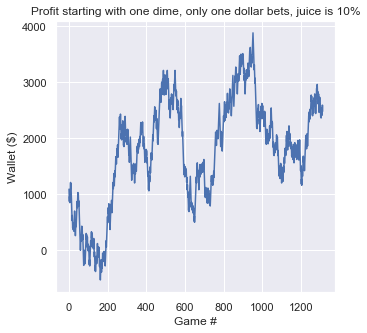

In [141]:
fig, ax = plt.subplots(figsize=(5,5))
ax.plot(pred_df.index, pred_df['wallet'])
plt.xlabel('Game #')
plt.ylabel('Wallet ($)')
plt.title('Profit starting with one dime, only one dollar bets, juice is 10%')
plt.show()

In [83]:
#PROFIT based on probabilities- Start with $1000, juice is 10%, $100 min
prob_df = pd.DataFrame(prob_final, columns=['0', '1'])
prob_df['actual'] = y_test_final.reset_index(drop=True)
prob_df['wallet'] = 0
prob_df = prob_df[::2].reset_index(drop=True)
prob_df.head()

,0,1,actual,wallet
0,0.560621,0.439379,0,0
1,0.522521,0.477479,0,0
2,0.527919,0.472081,0,0
3,0.436229,0.563771,1,0
4,0.503888,0.496112,1,0


In [101]:
prob_thresh = .55
prob_df['prediction'] = -1
for i in range(0, prob_df.shape[0]):
    if prob_df.iloc[i, prob_df.columns.get_loc('0')] > prob_thresh:
        prob_df.iloc[i, prob_df.columns.get_loc('prediction')] = 0
    if prob_df.iloc[i, prob_df.columns.get_loc('1')] > prob_thresh:
        prob_df.iloc[i, prob_df.columns.get_loc('prediction')] = 1
        
prob_df.head(20)

,0,1,actual,wallet,prediction
0,0.560621,0.439379,0,1090,0
1,0.522521,0.477479,0,1090,-1
2,0.527919,0.472081,0,1090,-1
3,0.436229,0.563771,1,1180,1
4,0.503888,0.496112,1,1180,-1
5,0.467414,0.532586,1,1270,-1
6,0.534002,0.465998,0,1360,-1
7,0.459544,0.540456,0,1250,-1
8,0.519536,0.480464,0,1250,-1
9,0.507558,0.492442,1,1250,-1


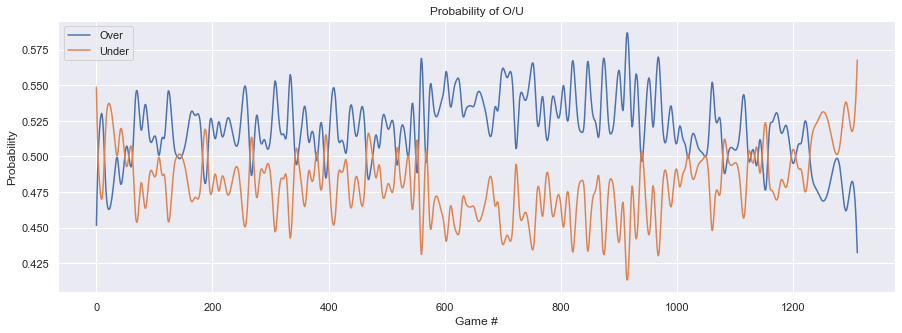

0.4837520808537404
0.5224180114794909


In [102]:
from scipy.interpolate import UnivariateSpline
# 300 represents number of points to make between T.min and T.max
xnew = np.linspace(prob_df.index.min(), prob_df.index.max(), prob_df.shape[0])  
spl0 = UnivariateSpline(prob_df.index, prob_df['0'])
spl1 = UnivariateSpline(prob_df.index, prob_df['1'])
spl0.set_smoothing_factor(3.25)
spl1.set_smoothing_factor(3.25)


fig, ax = plt.subplots(figsize=(15,5))
#ax.plot(prob_df.index, prob_df['0'])
ax.plot(prob_df.index, spl1(xnew), label = 'Over')
ax.plot(prob_df.index, spl0(xnew), label= 'Under')
#ax.plot(prob_df.index, prob_df['1'])
plt.xlabel('Game #')
plt.ylabel('Probability')
plt.legend()
plt.title('Probability of O/U')
plt.show()

#RMS
print(np.sqrt(np.mean(prob_df['0']**2)))
print(np.sqrt(np.mean(prob_df['1']**2)))

In [103]:
wallet = 1000
for i in range(0, prob_df.shape[0]):
    if i == 0:
        if prob_df.iloc[0, prob_df.columns.get_loc('prediction')] == -1:
            prob_df.iloc[0, prob_df.columns.get_loc('wallet')] = wallet
            continue
        if prob_df.iloc[0, prob_df.columns.get_loc('prediction')] == prob_df.iloc[0, 
            prob_df.columns.get_loc('actual')]:
            prob_df.iloc[0, prob_df.columns.get_loc('wallet')] = wallet + 90
        else:
            prob_df.iloc[0, prob_df.columns.get_loc('wallet')] = wallet - 110
    if i > 0:
        if prob_df.iloc[i, prob_df.columns.get_loc('prediction')] == -1:
            prob_df.iloc[i, prob_df.columns.get_loc('wallet')] = prob_df.iloc[i-1, prob_df.columns.get_loc('wallet')]
            continue
        if prob_df.iloc[i, prob_df.columns.get_loc('prediction')] == prob_df.iloc[i, 
            prob_df.columns.get_loc('actual')]:
            prob_df.iloc[i, prob_df.columns.get_loc('wallet')] = prob_df.iloc[i-1, 
                prob_df.columns.get_loc('wallet')] + 90
        else:
            prob_df.iloc[i, prob_df.columns.get_loc('wallet')] = prob_df.iloc[i-1, 
                prob_df.columns.get_loc('wallet')] - 110
prob_df.head()

,0,1,actual,wallet,prediction
0,0.560621,0.439379,0,1090,0
1,0.522521,0.477479,0,1090,-1
2,0.527919,0.472081,0,1090,-1
3,0.436229,0.563771,1,1180,1
4,0.503888,0.496112,1,1180,-1


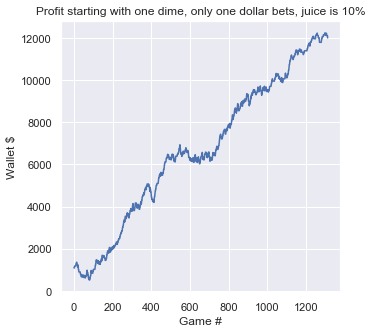

In [106]:
fig, ax = plt.subplots(figsize=(5,5))
ax.plot(prob_df.index, prob_df['wallet'])
plt.xlabel('Game #')
plt.ylabel('Wallet ($)')
plt.title('Profit starting with one dime, only one dollar bets, juice is 10%')
plt.show()

In [168]:
model = xgb.XGBRegressor(seed=294)
param_grid = {
    'eta': [.05],
    'n_estimators': [800],
}
#param_grid = {
#    'eta': [.005, .01, .05, .1],
#    'n_estimators': [100, 200, 400, 800, 1600],
#    'min_child_weight': [.8, 1, 1.2],
#    'colsample_bytree': [.8, 1, 1.2],
#    'max_depth': [3,4,5, 6, 7, 8, 9, 10, 15],
#    'reg_alpha': [.6, .8, .9, 1, 1.1],
#    'reg_lambda': [.6, .8, .9, 1, 1.1],
#    'subsample': [.6, 0.8, 1]
#}

fitted_model, pred = algorithm_pipeline(X_train_scaled, 
                                        X_test_scaled, y_train_cont, y_test_cont, model, 
                                        param_grid, cv=indices, scoring_fit = 'neg_mean_squared_error', 
                                        probabilities = False)

#Scores and parameters
print(round(np.sqrt(-fitted_model.best_score_), 3))
print(fitted_model.best_params_)
fits = pd.DataFrame(fitted_model.cv_results_)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   48.2s finished


18.509
{'eta': 0.05, 'n_estimators': 800}


In [169]:
y_test_cont.std()

17.37152451356122

In [ ]:
pred_final = fitted_model.predict(X_test_final_num[ext_game_mask])


In [ ]:
print(pred_final)

In [ ]:
y_test_cont_final

In [53]:
%%time
model = LGBMClassifier(seed=132)
param_grid = {
    'eta': [.05],
    'n_estimators': [800],
}
#param_grid = {
#    'eta': [.005, .01, .05, .1],
#    'n_estimators': [100, 200, 400, 800, 1600],
#    'min_child_weight': [.8, 1, 1.2],
#    'colsample_bytree': [.8, 1, 1.2],
#    'max_depth': [3,4,5, 6, 7, 8, 9, 10, 15],
#    'reg_alpha': [.6, .8, .9, 1, 1.1],
#    'reg_lambda': [.6, .8, .9, 1, 1.1],
#    'subsample': [.6, 0.8, 1]
#}

fitted_model, pred = algorithm_pipeline(X_train_scaled[ext_game_mask], X_test_scaled[ext_game_mask], y_train, 
                                        y_test, model, 
                                 param_grid, cv=indices, scoring_fit = 'accuracy', 
                                 probabilities = False)

#Scores and parameters
print(round(fitted_model.best_score_, 3))
print(fitted_model.best_params_)
fits = pd.DataFrame(fitted_model.cv_results_)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.9s finished


0.508
{'eta': 0.05, 'n_estimators': 800}
Wall time: 14.8 s


In [171]:
model = LogisticRegression(random_state=72)
param_grid = {
    'max_iter': [1000],
}
#param_grid = {
#    'eta': [.005, .01, .05, .1],
#    'n_estimators': [100, 200, 400, 800, 1600],
#    'min_child_weight': [.8, 1, 1.2],
#    'colsample_bytree': [.8, 1, 1.2],
#    'max_depth': [3,4,5, 6, 7, 8, 9, 10, 15],
#    'reg_alpha': [.6, .8, .9, 1, 1.1],
#    'reg_lambda': [.6, .8, .9, 1, 1.1],
#    'subsample': [.6, 0.8, 1]
#}

fitted_model, pred = algorithm_pipeline(X_train_scaled, X_test_scaled, y_train, 
                                        y_test, model, 
                                 param_grid, cv=indices, scoring_fit = 'neg_mean_squared_error', 
                                 probabilities = False)

#Scores and parameters
print(round(np.sqrt(-fitted_model.best_score_), 3))
print(fitted_model.best_params_)
fits = pd.DataFrame(fitted_model.cv_results_)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   13.3s finished
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [55]:
y_test.std()

0.499967145651772

In [ ]:
# make predictions for test data
y_pred = model.predict(X_test_2017_scaled[ext_game_mask])
predictions = [round(value) for value in y_pred]

# evaluate prediction
accuracy = accuracy_score(y_test_final, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

probas_train = model.predict_proba(X_train_2016_scaled[ext_game_mask])
log_loss_train = log_loss(y_train_2016, probas_train)
print(log_loss_train)

probas_test = model.predict_proba(X_test_2017_scaled[ext_game_mask])
log_loss_test = log_loss(y_test_2017, probas_test)
print(log_loss_test)

In [56]:
model = SVC(random_state=893, kernel = 'rbf')
param_grid = {
    'degree': [3],
}
#param_grid = {
#    'eta': [.005, .01, .05, .1],
#    'n_estimators': [100, 200, 400, 800, 1600],
#    'min_child_weight': [.8, 1, 1.2],
#    'colsample_bytree': [.8, 1, 1.2],
#    'max_depth': [3,4,5, 6, 7, 8, 9, 10, 15],
#    'reg_alpha': [.6, .8, .9, 1, 1.1],
#    'reg_lambda': [.6, .8, .9, 1, 1.1],
#    'subsample': [.6, 0.8, 1]
#}

fitted_model, pred = algorithm_pipeline(X_train_scaled[ext_game_mask], X_test_scaled[ext_game_mask], y_train, 
                                        y_test, model, 
                                 param_grid, cv=indices, scoring_fit = 'accuracy', 
                                 probabilities = False)

#Scores and parameters
print(round(fitted_model.best_score_, 3))
print(fitted_model.best_params_)
fits = pd.DataFrame(fitted_model.cv_results_)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.0s finished


0.506
{'degree': 3}


In [57]:
model = RandomForestClassifier(random_state=734)
param_grid = {
    'max_depth': [2],
}
#param_grid = {
#    'eta': [.005, .01, .05, .1],
#    'n_estimators': [100, 200, 400, 800, 1600],
#    'min_child_weight': [.8, 1, 1.2],
#    'colsample_bytree': [.8, 1, 1.2],
#    'max_depth': [3,4,5, 6, 7, 8, 9, 10, 15],
#    'reg_alpha': [.6, .8, .9, 1, 1.1],
#    'reg_lambda': [.6, .8, .9, 1, 1.1],
#    'subsample': [.6, 0.8, 1]
#}

fitted_model, pred = algorithm_pipeline(X_train_scaled[ext_game_mask], X_test_scaled[ext_game_mask], y_train, 
                                        y_test, model, 
                                 param_grid, cv=indices, scoring_fit = 'accuracy', 
                                 probabilities = False)

#Scores and parameters
print(round(fitted_model.best_score_, 3))
print(fitted_model.best_params_)
fits = pd.DataFrame(fitted_model.cv_results_)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   13.8s finished
C:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.505
{'max_depth': 2}


In [58]:
model = GaussianNB()
param_grid = {
    'var_smoothing': [10**-9],
}
#param_grid = {
#    'eta': [.005, .01, .05, .1],
#    'n_estimators': [100, 200, 400, 800, 1600],
#    'min_child_weight': [.8, 1, 1.2],
#    'colsample_bytree': [.8, 1, 1.2],
#    'max_depth': [3,4,5, 6, 7, 8, 9, 10, 15],
#    'reg_alpha': [.6, .8, .9, 1, 1.1],
#    'reg_lambda': [.6, .8, .9, 1, 1.1],
#    'subsample': [.6, 0.8, 1]
#}

fitted_model, pred = algorithm_pipeline(X_train_scaled[ext_game_mask], X_test_scaled[ext_game_mask], y_train, 
                                        y_test, model, 
                                 param_grid, cv=indices, scoring_fit = 'accuracy', 
                                 probabilities = False)

#Scores and parameters
print(round(fitted_model.best_score_, 3))
print(fitted_model.best_params_)
fits = pd.DataFrame(fitted_model.cv_results_)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


0.502
{'var_smoothing': 1e-09}


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.3s finished


In [59]:
pred_final = fitted_model.predict(X_test_final_scaled[ext_game_mask])
predictions = [round(value) for value in pred_final]

# evaluate prediction
accuracy = accuracy_score(y_test_final, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 52.78%


In [60]:
model = KNeighborsClassifier()
param_grid = {
    #'n_neighbors': np.array(range(25,40)),
    'n_neighbors': [35],
}
#param_grid = {
#    'eta': [.005, .01, .05, .1],
#    'n_estimators': [100, 200, 400, 800, 1600],
#    'min_child_weight': [.8, 1, 1.2],
#    'colsample_bytree': [.8, 1, 1.2],
#    'max_depth': [3,4,5, 6, 7, 8, 9, 10, 15],
#    'reg_alpha': [.6, .8, .9, 1, 1.1],
#    'reg_lambda': [.6, .8, .9, 1, 1.1],
#    'subsample': [.6, 0.8, 1]
#}

fitted_model, pred = algorithm_pipeline(X_train_scaled[ext_game_mask], X_test_scaled[ext_game_mask], y_train, 
                                        y_test, model, 
                                 param_grid, cv=indices, scoring_fit = 'accuracy', 
                                 probabilities = False)

#Scores and parameters
print(round(fitted_model.best_score_, 3))
print(fitted_model.best_params_)
fits = pd.DataFrame(fitted_model.cv_results_)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.1s finished


0.494
{'n_neighbors': 35}


In [66]:
model = LinearRegression()
param_grid = {
    'fit_intercept': [False]
    #'n_neighbors': np.array(range(25,40)),
    #'estimator': ['ridge', 'lasso'],
    #'alpha': [.01, .001, .1]
}
#param_grid = {
#    'eta': [.005, .01, .05, .1],
#    'n_estimators': [100, 200, 400, 800, 1600],
#    'min_child_weight': [.8, 1, 1.2],
#    'colsample_bytree': [.8, 1, 1.2],
#    'max_depth': [3,4,5, 6, 7, 8, 9, 10, 15],
#    'reg_alpha': [.6, .8, .9, 1, 1.1],
#    'reg_lambda': [.6, .8, .9, 1, 1.1],
#    'subsample': [.6, 0.8, 1]
#}

fitted_model, pred = algorithm_pipeline(X_train_scaled[ext_game_mask], X_test_scaled[ext_game_mask], y_train_cont, 
                                        y_test_cont, model, 
                                 param_grid, cv=indices, scoring_fit = 'neg_mean_squared_error', 
                                 probabilities = False)

#Scores and parameters
print(round(np.sqrt(-fitted_model.best_score_), 3))
print(fitted_model.best_params_)
fits = pd.DataFrame(fitted_model.cv_results_)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   20.0s finished


17.462
{'fit_intercept': False}


In [27]:
cat_feat_ind = (X_train_2016[ext_game_mask].dtypes == 'object').nonzero()[0]
pool_train = Pool(X_train_2016[ext_game_mask], y_train_2016, cat_features=cat_feat_ind)
pool_val = Pool(X_test_2017[ext_game_mask], y_test_2017, cat_features=cat_feat_ind)
pool_test = Pool(X_test_final[ext_game_mask], y_test_final, cat_features=cat_feat_ind)

n = y_train_2016.value_counts()
model = CatBoostClassifier(learning_rate=.001,
                           iterations=500,
                           depth=3,
                           l2_leaf_reg=10,
                           random_strength=5,
                           #bagging_temperature=1,
                           #grow_policy='Lossguide',
                           #min_data_in_leaf=1,
                           #max_leaves=1,
                           early_stopping_rounds=100,
                           class_weights=[1, n[0] / n[1]],
                           verbose=False,
                           random_state=534)
model.fit(pool_train, eval_set=pool_val, plot=True);

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  """Entry point for launching an IPython kernel.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Accuracy (test): 0.530
Precision (test): 0.524
Recall (test): 0.876


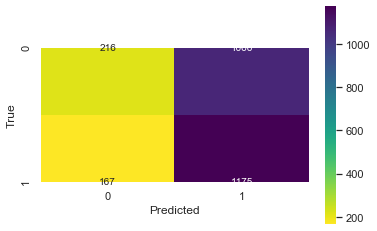

In [28]:
y_pred_test = model.predict(pool_test)

acc_test = accuracy_score(y_test_final, y_pred_test)
prec_test = precision_score(y_test_final, y_pred_test)
rec_test = recall_score(y_test_final, y_pred_test)
print(f'''Accuracy (test): {acc_test:.3f}
Precision (test): {prec_test:.3f}
Recall (test): {rec_test:.3f}''')

cm = confusion_matrix(y_test_final, y_pred_test)
ax = sns.heatmap(cm, cmap='viridis_r', annot=True, fmt='d', square=True)
ax.set_xlabel('Predicted')
ax.set_ylabel('True');

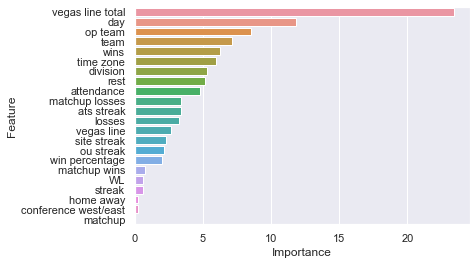

In [238]:
feat = model.feature_names_
imp = model.feature_importances_
df = pd.DataFrame({'Feature': feat, 'Importance': imp})
df = df.sort_values('Importance', ascending=False)
sns.barplot(x='Importance', y='Feature', data=df);